In [4]:
from pandas_datareader import data
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Establishing Dates
start = "2016-06-01"
end = datetime.today().strftime('%Y-%m-%d')

# Establishing Assets
assets = ['VTI', 'BND', 'VUG', 'VTXVX', 'VNQ']

#252 trading days in a year
N = 252

#1% risk free rate
rf =0.02

# Creating an empty dataframe
df_prices = pd.DataFrame()

# Getting the "Adj Close" data from Yahoo Finance by defining a function
# This function lists the price data as daily percent change 
# This function also drops the NA first row
def YahooData(dataframe, assets_list, start_date, end_date):
    for i in assets_list:
        dataframe[i] = data.DataReader(i, data_source = "yahoo", start=start_date, end=end_date)['Adj Close']
    return dataframe

# Running the function that we just made and saving the results to the DataFrame
df = YahooData(df_prices, assets, start, end)

# Calculating Log Return
df = np.log(df/df.shift(1))

# Dropping the first row because it's N/A
df = df.dropna()

# Viewing df head
df


,VTI,BND,VUG,VTXVX,VNQ
Date,,,,,
2016-06-02,0.003339,0.001934,0.003502,0.001361,0.005122
2016-06-03,-0.002782,0.006259,-0.002395,0.003396,0.004031
2016-06-06,0.005187,-0.001561,0.002670,0.002032,-0.007721
2016-06-07,0.001938,0.000120,0.000736,0.002703,0.006063
2016-06-08,0.003497,0.001201,0.003486,0.002695,0.006380
...,...,...,...,...,...
2021-05-28,0.001698,-0.000117,0.002662,0.001236,0.006025
2021-06-01,0.000413,-0.000070,-0.003476,0.001234,0.017861
2021-06-02,0.001328,0.001057,0.001111,0.000617,0.011635


In [6]:
# Creating 10000 random simulations of each portfolio weight configuration
num_runs = 10000 # number of rows/iterations

# Creating a Matrix with 10000 rows, with each row representing a random portfolio:
    #first 3 columns are Mean Returns, Standard Deviation, and Sortino Ratio
    # remaining columns are each assets random weight within that random portfolio
result = np.zeros((num_runs,(len(assets)+5)))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
#df = df.copy()
for i in range(num_runs):
    
    # randomized weights
    weights = np.array(np.random.random(len(assets))) 
    #Rebalance w/ constraints (SUM of all weights CANNOT BE > 1)
    weights = weights/np.sum(weights)
    
    # daily return of the portfolio based on a given set of weights
    df['portfolio_ret'] = df.iloc[:,0]*weights[0]+df.iloc[:,1]*weights[1]+df.iloc[:,2]*weights[2]
    
    # Calculating Mean
    E = df['portfolio_ret'].mean()
    # Annualizing Mean
    E_AN = E * N
    
    # Calculating Downside Standard Deviation
    mean = E * N -rf
    std_neg = df['portfolio_ret'][df['portfolio_ret']<0].std()*np.sqrt(N)
    
    
    # Calculating Upside Standard Deviation
    std_pos = df['portfolio_ret'][df['portfolio_ret']>=0].std()*np.sqrt(N)
    
    # Calculating Volatility Skewness
    VS = std_pos/std_neg
    
    # Sortino
    Sortino = mean/std_neg
   
    # Populating the 'result' array with the required values: Mean, SD, Sharpe followed by the weights                   
    result[i,0] = E_AN
    result[i,1] = std_neg
    result[i,2] = std_pos
    result[i,3] = VS
    result[i,4] = Sortino
    
    for j in range(len(assets)):
        result[i,j+5]= weights[j]

In [8]:
# Converting 'result' into a DataFrame

columns = ['Mean','Downside SD', 'Upside SD', 'Volatility Skewness', 'Sortino'] + assets

result = pd.DataFrame(result,columns=columns)
result

,Mean,Downside SD,Upside SD,Volatility Skewness,Sortino,VTI,BND,VUG,VTXVX,VNQ
0,0.073834,0.071990,0.053175,0.738641,0.747802,0.041429,0.034005,0.339213,0.185130,0.400223
1,0.087835,0.094630,0.068844,0.727512,0.716844,0.389435,0.018231,0.126291,0.085514,0.380529
2,0.052897,0.052152,0.037319,0.715587,0.630797,0.142473,0.164500,0.125809,0.232238,0.334979
3,0.065851,0.063380,0.045597,0.719422,0.723431,0.114806,0.196553,0.209720,0.285492,0.193429
4,0.092630,0.090988,0.066869,0.734924,0.798235,0.142947,0.101822,0.340258,0.102583,0.312390
...,...,...,...,...,...,...,...,...,...,...
9995,0.036949,0.036748,0.026748,0.727891,0.461215,0.090091,0.064560,0.104295,0.388841,0.352213
9996,0.084887,0.085679,0.062027,0.723954,0.757326,0.272616,0.180667,0.179831,0.361877,0.005009
9997,0.097854,0.097781,0.071180,0.727948,0.796207,0.268072,0.182215,0.249932,0.189355,0.110427
9998,0.091365,0.090951,0.065556,0.720783,0.784652,0.258423,0.229394,0.216483,0.142689,0.153010


In [9]:
# Finding Maximum Sortino Ratio
Max_Sortino = result.iloc[result['Sortino'].idxmax()]
Max_Sortino

Mean                   0.148745
Downside SD            0.141597
Upside SD              0.103950
Volatility Skewness    0.734131
Sortino                0.909241
VTI                    0.008566
BND                    0.186268
VUG                    0.725075
VTXVX                  0.000157
VNQ                    0.079935
Name: 2558, dtype: float64

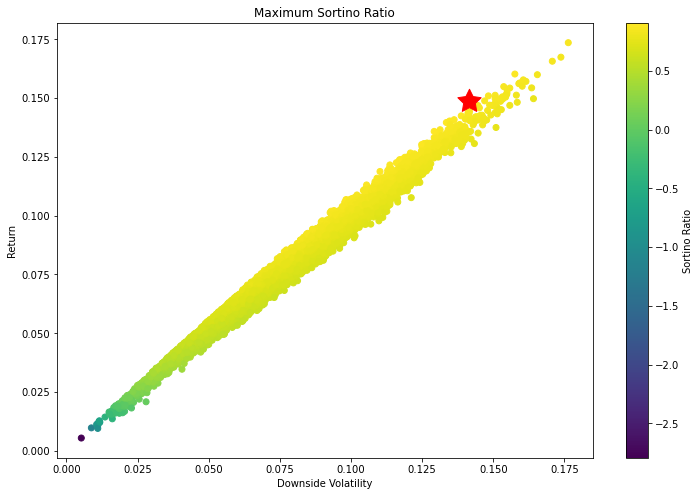

In [10]:
# Creating plot with maximum sortino ratio
plt.figure(figsize=(12,8))
plt.scatter(x=result['Downside SD'],y=result['Mean'],c=result['Sortino'],cmap='viridis')
plt.colorbar(label='Sortino Ratio')
plt.xlabel('Downside Volatility')
plt.ylabel('Return')

plt.title('Maximum Sortino Ratio')
#Plot a red star to highlight position of the portfolio with highest Sortino Ratio
plt.scatter(Max_Sortino[1],Max_Sortino[0],marker=(5,1,0),color='r',s=600)

plt.show()